<a href="https://colab.research.google.com/github/lmrhody/femethodsS23/blob/main/Week14notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic models with Gensim

Gensim is a popular library for topic modeling. Here we'll see how it stacks up to scikit-learn.

### Prep work: Downloading necessary files
Before we get started, we need to download all of the data we'll be using.
* **recipes.csv:** recipes - a list of recipes (but only with ingredient names)
* **state-of-the-union.csv:** State of the Union addresses - each presidential address from 1970 to 2012


In [1]:
# Make data directory if it doesn't exist
!mkdir -p data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv -P data
!wget -nc https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv -P data
!pip install pyLDAvis==2.1.2

--2023-05-08 10:59:43--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/recipes.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6483086 (6.2M) [text/csv]
Saving to: ‘data/recipes.csv’

recipes.csv         100%[===================>]   6.18M  4.35MB/s    in 1.4s    

2023-05-08 10:59:46 (4.35 MB/s) - ‘data/recipes.csv’ saved [6483086/6483086]

--2023-05-08 10:59:46--  https://nyc3.digitaloceanspaces.com/ml-files-distro/v1/text-analysis/data/state-of-the-union.csv
Resolving nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)... 162.243.189.2
Connecting to nyc3.digitaloceanspaces.com (nyc3.digitaloceanspaces.com)|162.243.189.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10501219 (10M) [text/csv]
Saving to: ‘data/state-of-the-union

## Gensim vs. Scikit-learn

[Gensim](https://radimrehurek.com/gensim/) is a very very popular piece of software to do topic modeling with (as is [Mallet](http://mallet.cs.umass.edu/topics.php), if you're making a list). Since we're using scikit-learn for everything else, though, we use scikit-learn instead of Gensim when we get to topic modeling.

Since someone might show up one day offering us tens of thousands of dollars to demonstrate proficiency in Gensim, though, we might as well see how it works as compared to scikit-learn.

## Our data

We'll be using the same dataset as we did [with scikit-learn](/text-analysis/introduction-to-topic-modeling/#Attempt-two:-State-of-the-Union-addresses): State of the Union addresses from 1790 to 2012, where America's president addresses the Congress about the coming year.

In [2]:
import pandas as pd

df = pd.read_csv("data/state-of-the-union.csv")

# Clean it up a little bit, removing non-word characters (numbers and ___ etc)
df.content = df.content.str.replace("[^A-Za-z ]", " ")

df.head()

<ipython-input-2-4699dee7d493>:6: FutureWarning: The default value of regex will change from True to False in a future version.
  df.content = df.content.str.replace("[^A-Za-z ]", " ")


,year,content
0,1790,George Washington January Fellow Citi...
1,1790,State of the Union Address George Washington ...
2,1791,State of the Union Address George Washington ...
3,1792,State of the Union Address George Washington ...
4,1793,State of the Union Address George Washington ...


## Using Gensim

In [3]:
#!pip install --upgrade gensim

In [4]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [5]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5)

corpus = [dictionary.doc2bow(text) for text in texts]

In [6]:
from gensim import models

tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]

In [7]:
n_topics = 15

# Build an LSI model
lsi_model = models.LsiModel(corpus_tfidf,
                            id2word=dictionary,
                            num_topics=n_topics)

In [8]:
lsi_model.print_topics()

[(0,
  '0.084*"tonight" + 0.073*"program" + 0.066*"ve" + 0.065*"help" + 0.065*"budget" + 0.065*"mexico" + 0.065*"americans" + 0.061*"programs" + 0.059*"jobs" + 0.058*"re"'),
 (1,
  '-0.206*"tonight" + -0.169*"ve" + -0.137*"re" + -0.136*"jobs" + -0.130*"americans" + -0.124*"budget" + -0.123*"help" + -0.116*"programs" + -0.112*"program" + -0.106*"billion"'),
 (2,
  '-0.199*"tonight" + -0.177*"ve" + -0.164*"re" + 0.137*"program" + -0.094*"jobs" + -0.092*"ll" + 0.092*"farm" + -0.091*"iraq" + 0.087*"veterans" + 0.081*"industrial"'),
 (3,
  '-0.141*"program" + 0.120*"silver" + 0.114*"re" + 0.110*"cent" + -0.106*"communist" + 0.105*"ve" + 0.098*"tonight" + -0.097*"soviet" + -0.095*"programs" + 0.090*"gold"'),
 (4,
  '-0.196*"iraq" + -0.171*"terrorists" + 0.142*"silver" + 0.132*"gold" + -0.125*"interstate" + -0.117*"iraqi" + 0.111*"programs" + -0.110*"al" + 0.103*"soviet" + 0.101*"notes"'),
 (5,
  '-0.274*"iraq" + -0.236*"terrorists" + 0.184*"re" + 0.182*"ve" + -0.169*"iraqi" + -0.153*"al" + -

Gensim is all about how important each word is to the category. Why not visualize it? First we'll make a dataframe that shows each topic, its top five words, and its values.

In [9]:
n_words = 10

topic_words = pd.DataFrame({})

for i, topic in enumerate(lsi_model.get_topics()):
    top_feature_ids = topic.argsort()[-n_words:][::-1]
    feature_values = topic[top_feature_ids]
    words = [dictionary[id] for id in top_feature_ids]
    topic_df = pd.DataFrame({'value': feature_values, 'word': words, 'topic': i})
    topic_words = pd.concat([topic_words, topic_df], ignore_index=True)

topic_words.head()

,value,word,topic
0,0.083989,tonight,0
1,0.073468,program,0
2,0.065718,ve,0
3,0.065224,help,0
4,0.065022,budget,0


Then we'll use seaborn to visualize it.

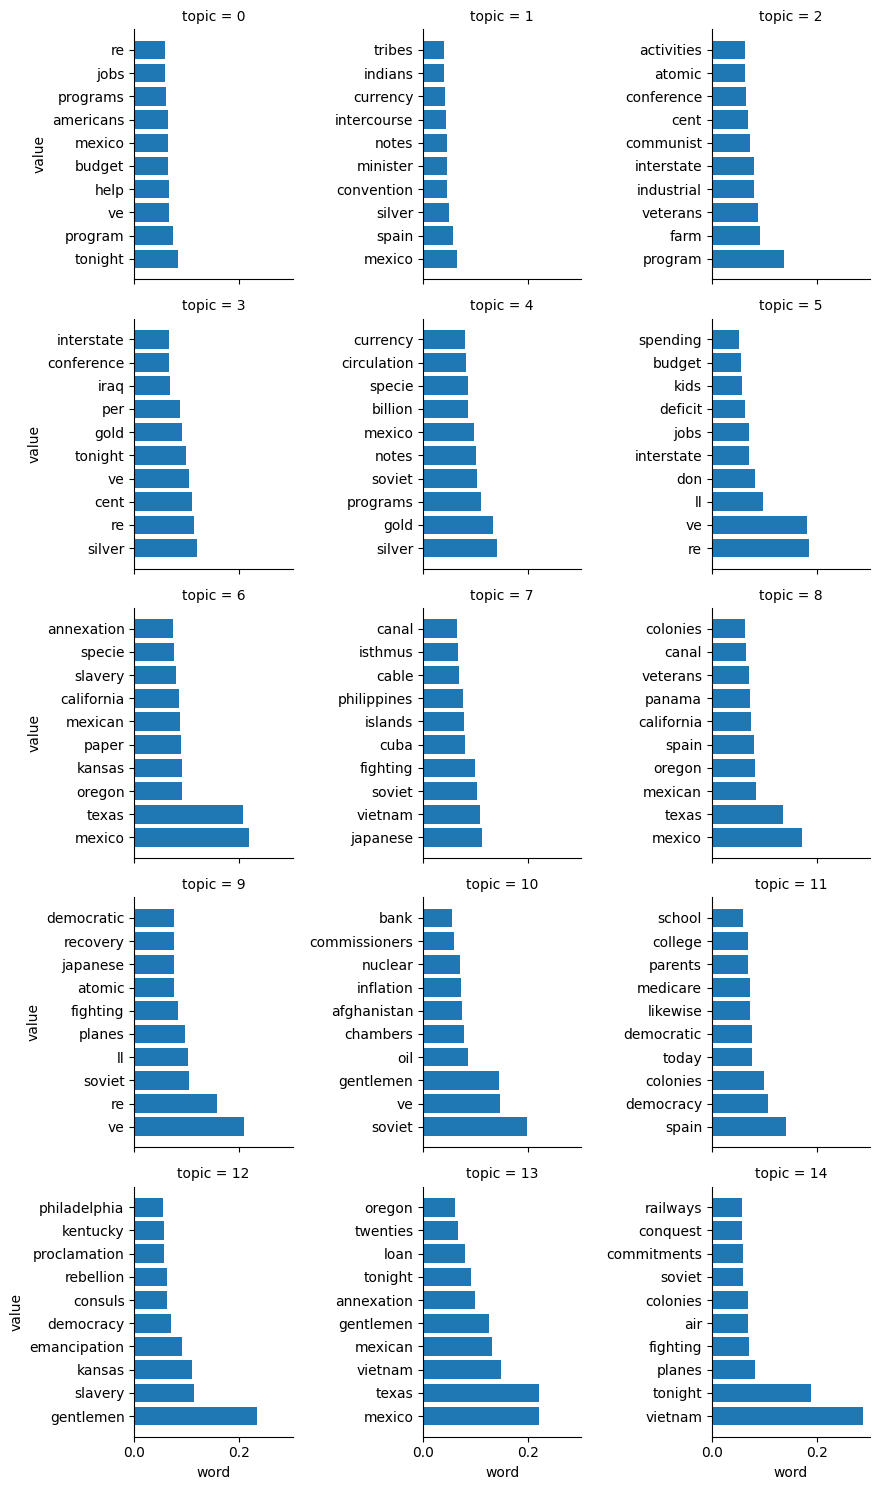

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(topic_words, col="topic", col_wrap=3, sharey=False)
g.map(plt.barh, "word", "value")

## Using LDA with Gensim

Now we'll use LDA.

In [11]:
from gensim.utils import simple_preprocess

texts = df.content.apply(simple_preprocess)

In [12]:
from gensim import corpora

dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.5, keep_n=2000)
corpus = [dictionary.doc2bow(text) for text in texts]

In [13]:
from gensim import models

n_topics = 15

lda_model = models.LdaModel(corpus=corpus, num_topics=n_topics)

In [14]:
lda_model.print_topics()

[(0,
  '0.003*"1260" + 0.003*"1559" + 0.003*"1986" + 0.003*"1626" + 0.003*"1971" + 0.002*"1784" + 0.002*"151" + 0.002*"1922" + 0.002*"1930" + 0.002*"468"'),
 (1,
  '0.004*"1559" + 0.003*"151" + 0.003*"440" + 0.003*"1446" + 0.003*"1986" + 0.002*"1327" + 0.002*"1626" + 0.002*"1260" + 0.002*"81" + 0.002*"1017"'),
 (2,
  '0.004*"1986" + 0.004*"1930" + 0.004*"1971" + 0.004*"1242" + 0.003*"1260" + 0.003*"1989" + 0.003*"1974" + 0.002*"1559" + 0.002*"1995" + 0.002*"1988"'),
 (3,
  '0.004*"1986" + 0.003*"1971" + 0.003*"1930" + 0.003*"1260" + 0.003*"1999" + 0.003*"1242" + 0.003*"1559" + 0.003*"1995" + 0.003*"151" + 0.002*"1964"'),
 (4,
  '0.003*"1986" + 0.002*"62" + 0.002*"976" + 0.002*"57" + 0.002*"152" + 0.002*"151" + 0.002*"440" + 0.002*"613" + 0.002*"1559" + 0.002*"1545"'),
 (5,
  '0.007*"1559" + 0.003*"1626" + 0.003*"1327" + 0.003*"976" + 0.003*"151" + 0.002*"62" + 0.002*"440" + 0.002*"951" + 0.002*"1260" + 0.002*"1619"'),
 (6,
  '0.007*"1260" + 0.005*"1930" + 0.004*"1986" + 0.004*"1964" + 

In [15]:
import pyLDAvis
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary)
vis

/usr/local/lib/python3.10/dist-packages/pyLDAvis/_prepare.py:232: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.012433 -0.005962       1        1  26.938323
6     -0.021316 -0.000674       2        1  24.189202
1      0.006324  0.004317       3        1  10.862697
4      0.010009  0.003592       4        1   7.606421
7      0.009178  0.001319       5        1   7.168913
13     0.004994  0.000513       6        1   4.842805
14    -0.006596  0.001061       7        1   4.433379
11     0.003202 -0.003020       8        1   3.588451
9      0.001149  0.000166       9        1   3.006247
0     -0.000397 -0.000299      10        1   1.641671
10    -0.003727  0.003148      11        1   1.422028
12     0.000668 -0.001351      12        1   1.230005
3     -0.006728 -0.000427      13        1   1.195046
8     -0.003098 -0.002191      14        1   1.065199
2     -0.006094 -0.000193      15        1   0.809614, topic_info=            Term         Freq        Total Category  logprob  loglift
1260   americans   877.000000   877.000000  Default  30.0000  30.0000
1930        help   792.000000   792.000000  Default  29.0000  29.0000
1986     program   710.000000   710.000000  Default  28.0000  28.0000
1559      mexico  1036.000000  1036.000000  Default  27.0000  27.0000
1971      budget   549.000000   549.000000  Default  26.0000  26.0000
...          ...          ...          ...      ...      ...      ...
57       indians     3.306850   400.086726  Topic15  -6.4606   0.0207
1651        bill     3.280096   377.511483  Topic15  -6.4687   0.0706
19      currency     3.287110   398.076288  Topic15  -6.4666   0.0197
151   convention     3.382807   597.294675  Topic15  -6.4379  -0.3573
1626         per     3.324806   584.291351  Topic15  -6.4552  -0.3526

[1026 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
254       1  0.280167  abundance
254       2  0.175104  abundance
254       3  0.105063  abundance
254       4  0.052531  abundance
254       5  0.087552  abundance
...     ...       ...        ...
1796     11  0.020400      young
1796     12  0.010200      young
1796     13  0.015300      young
1796     14  0.015300      young
1796     15  0.010200      young

[7654 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 7, 2, 5, 8, 14, 15, 12, 10, 1, 11, 13, 4, 9, 3])